# Example for life cycle assessment module of AeroMAPS


## Load and process

First, the user has to load the framework and generate a process.

In [1]:
%matplotlib widget
import pandas as pd
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_bottom_up,
    models_energy_without_fuel_effect,
    models_offset,
    models_climate_simple_gwpstar,
    models_sustainability,
)
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_numeric import FleetEvolution
from aeromaps.models.impacts.life_cycle_assessment.life_cycle_assessment import LifeCycleAssessment

In [2]:
extended_models = {
    "models_traffic": models_traffic,
    "models_efficiency_bottom_up": models_efficiency_bottom_up,
    "models_energy_without_fuel_effect": models_energy_without_fuel_effect,
    "models_offset": models_offset,
    "models_climate_simple_gwpstar": models_climate_simple_gwpstar,
    "models_sustainability": models_sustainability,
    "fleet_numeric": FleetEvolution("fleet_numeric"),
    "life_cycle_assessment": LifeCycleAssessment(
        "life_cycle_assessment",
        reset=False,
    )
}

Initial setup of EcoInvent/Premise already done, skipping. To reset the project use option `reset=True`.
Building LCA model from configuration file... Done.
Parametrizing LCIA impacts... Done.


In [3]:
process = create_process(
    configuration_file="data_files/config.json",
    models=extended_models,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=True
)

In [ ]:
#process.list_float_inputs()

## Compute

Once all the parameters have been set up, the user can compute.

In [4]:
import time
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

--- 42.28629398345947 seconds ---


## Results

The user can then display the results. The user has access to float outputs but also to annual data outputs, with the possibility of choosing the output.

In [7]:
#process.data['vector_outputs']

In [8]:
#process.climate_outputs_df

In [5]:
process.lca_outputs_df.T

method acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]  \
phase                                                                            _other_   
2020                                                                                   0   
2021                                                                                   0   
2022                                                                                   0   
2023                                                                                   0   
2024                                                                                   0   
2025                                                                                   0   
2026                                                                                   0   
2027                                                                                   0   
2028                                                                                   0   
2029                                                                                   0   
2030                                                                                   0   
2031                                                                                   0   
2032                                                                                   0   
2033                                                                                   0   
2034                                                                                   0   
2035                                                                                   0   
2036                                                                                   0   
2037                                                                                   0   
2038                                                                                   0   
2039                                                                                   0   
2040                                                                                   0   
2041                                                                                   0   
2042                                                                                   0   
2043                                                                                   0   
2044                                                                                   0   
2045                                                                                   0   
2046                                                                                   0   
2047                                                                                   0   
2048                                                                                   0   
2049                                                                                   0   
2050                                                                                   0   

method                                                         \
phase  aircraft_production     airport combustion_electrofuel   
2020                     0 3.83535e+07                      0   
2021            2.1906e+07 5.49552e+07                      0   
2022           2.44557e+07 7.02426e+07                      0   
2023           2.64918e+07 8.42158e+07                      0   
2024            2.7749e+07 9.68748e+07                      0   
2025            3.2133e+07 9.56791e+07                      0   
2026           3.50031e+07 9.60544e+07                      0   
2027           3.52323e+07 9.63661e+07                      0   
2028           3.44833e+07   9.661e+07                      0   
2029            3.2974e+07 9.67818e+07                      0   
2030           3.09879e+07  9.6877e+07                      0   
2031           2.86743e+07 9.77737e+07                      0   
2032           2.64184e+07  9.8637e+07               

## Plots

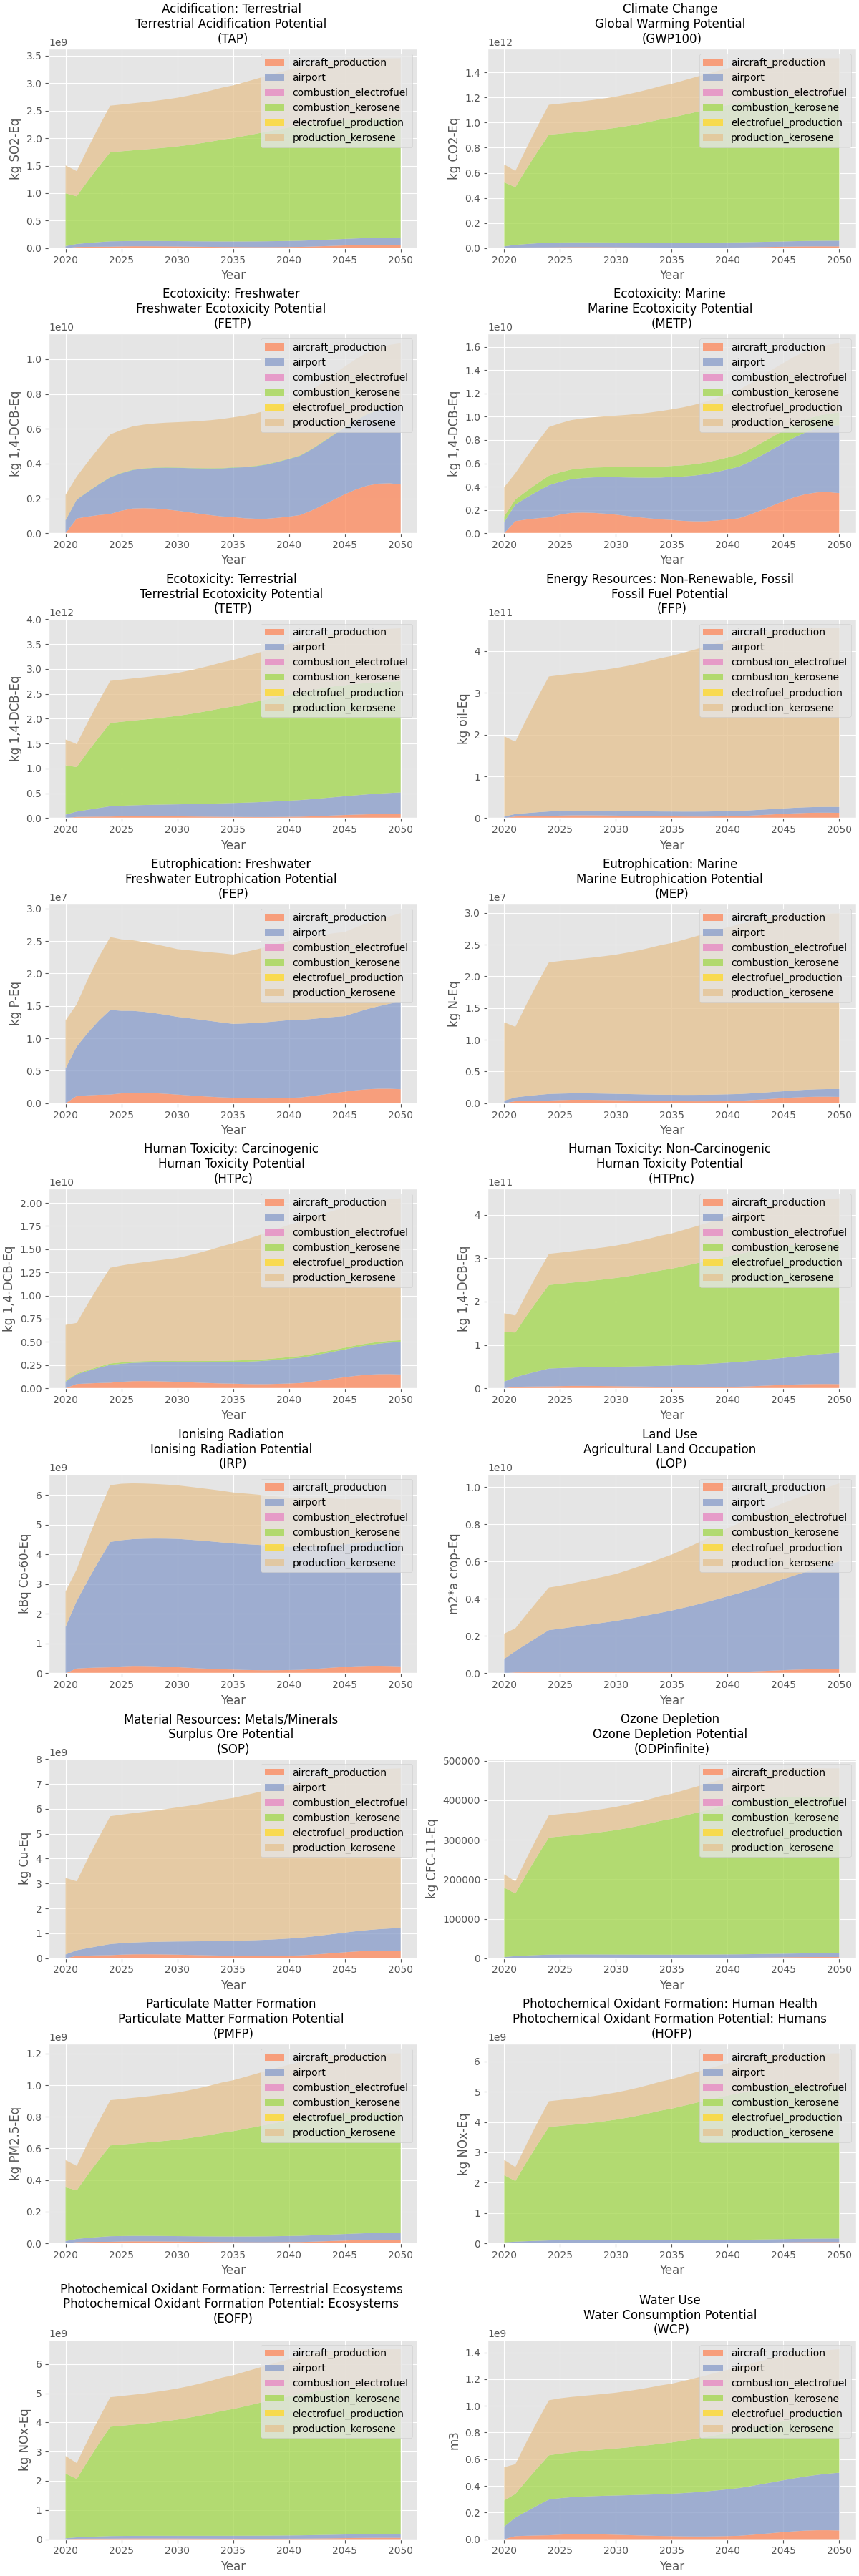

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('ggplot')

def plot_stacked_evolution_subplots(df):
    # Remove phases containing 'sum'
    df_filtered = df[~df.index.get_level_values('phase').str.contains('sum')]
    
    methods = df_filtered.index.get_level_values('method').unique()
    years = df_filtered.columns
    
    # Determine the number of rows and columns for the subplots
    n_methods = len(methods)
    n_cols = 2 if n_methods % 2 == 0 else 3
    n_rows = math.ceil(n_methods / n_cols)
    
    # Use seaborn color palette for better aesthetics
    palette = sns.color_palette("Set2", len(df_filtered.index.levels[1]))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4), constrained_layout=True)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, method in enumerate(methods):
        df_method = df_filtered.xs(method, level='method')
        #df_method.index = df_method.index.str.replace('_', ' ')
        
        # Plot stacked area chart with custom colors
        axes[i].stackplot(years, df_method, labels=df_method.index, alpha=0.8, colors=palette)
        
        # Customize the subplot
        name, unit = method.split('[', 1)
        name = name.replace('- ', '\n').replace('(', '\n(')
        name = "".join([a if a.isupper() else b for a,b in zip(name,name.title())])
        unit = unit.replace(']', '')
        axes[i].set_title(name, fontsize=12)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel(unit)
        axes[i].grid(True)
        axes[i].legend()
    
    # Remove any empty subplots
    #for j in range(i + 1, len(axes)):
    #    fig.delaxes(axes[j])
    
    # Add a single legend for all subplots
    #handles, labels = axes[0].get_legend_handles_labels()
    #fig.legend(handles, labels, title='Phase', loc='upper center', ncol=4, bbox_to_anchor = (0, 0.05, 1, 1), mode="expand") #, ncol=len(df_filtered.index.levels[1]))
        
    plt.show()

# Call the function
plot_stacked_evolution_subplots(process.lca_outputs_df)

# Draft

In [ ]:
from functools import wraps

def kwargs_decorator():
    def wrapper(f):
        @wraps(f)
        def inner_wrapper(*args, **kwargs):
            dict_kwargs = args[0].lca_params
            new_kwargs = {**dict_kwargs, **kwargs}
            return f(*args, **new_kwargs)
        return inner_wrapper
    return wrapper

class Test:
    def __init__(self):
        self.lca_params = {'a': 1.0}
        
    @kwargs_decorator()
    def foo(self, **kwargs):
        print(kwargs)

In [ ]:
test = Test()
test.foo()

In [ ]:
from functools import wraps
import lca_algebraic as agb

def kwargs_decorator(dict_kwargs):
    def wrapper(f):
        @wraps(f)
        def inner_wrapper(*args, **kwargs):
            # dict_kwargs = args[0].my_dict  # args[0] refer to 'self'
            new_kwargs = {**dict_kwargs, **kwargs}
            return f(*args, **new_kwargs)
        return inner_wrapper
    return wrapper


def args_decorator(list_args):
    def wrapper(f):
        @wraps(f)
        def inner_wrapper(*args, **kwargs):
            # dict_kwargs = args[0].my_dict  # args[0] refer to 'self'
            new_args = {*args, *list_args}
            return f(*new_args, **kwargs)
        return inner_wrapper
    return wrapper


class Test:
        
    @args_decorator(agb.all_params().keys())
    def foo(self, *args, **kwargs):
        return args
    
    
test = Test()
test.__init__()
res = test.foo()
res

In [ ]:
from inspect import getfullargspec

getfullargspec(test.foo)

In [ ]:
list(agb.all_params().keys())

In [ ]:
class Test:
    def init(self):
        self.my_list = ['a', 'b']
    
    def foo(self, *args, **kwargs):
        
        
        def foo2(
        
        return args
    

In [ ]:
test = ['q', 1.0]

any(isinstance(elem, str) for elem in test)

In [99]:
agb.findMethods?

Signature: agb.findMethods(search=None, mainCat=None)
Docstring:
Find impact method. Search in all methods against a list of match strings.
Each parameter can be either an exact match, or case-insensitive search, if suffixed by '*'

Parameters
----------
search :
    String to search
mainCat :
    If specified, limits the research for method[0] == mainCat.


Returns
-------
A list of tuples, identifying the methods.
File:      /opt/miniconda3/envs/aeromaps-dev/lib/python3.10/site-packages/lca_algebraic/methods.py
Type:      function

In [110]:
import lca_algebraic as agb

agb.findMethods('',mainCat='ReCiPe 2016 v1.03, midpoint (H)')

[('ReCiPe 2016 v1.03, midpoint (H)',
  'acidification: terrestrial',
  'terrestrial acidification potential (TAP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'climate change',
  'global warming potential (GWP100)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'ecotoxicity: freshwater',
  'freshwater ecotoxicity potential (FETP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'ecotoxicity: marine',
  'marine ecotoxicity potential (METP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'ecotoxicity: terrestrial',
  'terrestrial ecotoxicity potential (TETP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'energy resources: non-renewable, fossil',
  'fossil fuel potential (FFP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'eutrophication: freshwater',
  'freshwater eutrophication potential (FEP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'eutrophication: marine',
  'marine eutrophication potential (MEP)'),
 ('ReCiPe 2016 v1.03, midpoint (H)',
  'human toxicity: carcinogenic',
  'human toxicity potential (HTPc)'),
 ('Re

In [4]:
import brightway2 as bw
from dotenv import load_dotenv
import bw2io
import bw2data
import os
import lca_algebraic as agb

bw2data.projects.set_current('example_methodology_ei391')
db = bw.Database('ecoinvent_cutoff_3.9_remind_SSP2-Base_2020')

In [12]:
[act for act in db if 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis' in act['name']]

['kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation' (kilogram, EUR, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation' (kilogram, RER, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation' (kilogram, LAM, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation' (kilogram, OAS, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation' (kilogram, SSA, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, economic allocation' (kilogram, RER, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation' (kilogram, NEU, None),
 'kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy a